<a href="https://colab.research.google.com/github/beardybutler/Projects/blob/master/Pixray_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#@title #**pixray_install** { vertical-output: true }
#@markdown Run this once, then "Runtime > Restart Runtime"
install = True #@param {type:"boolean"} 

# gpu check
nvidia_output = !nvidia-smi --query-gpu=memory.total --format=noheader,nounits,csv
gpu_memory = int(nvidia_output[0])
if gpu_memory < 14000:
  print(f"--> GPU check: ONLY {gpu_memory} MiB available: WARNING, some things might not work <--")
else:
  print(f"GPU check: {gpu_memory} MiB available: this should be fine")

# install
if install:
  print("Installing...")
  from IPython.utils import io
  with io.capture_output() as captured:
    !rm -Rf pixray
    !git clone --recursive https://github.com/pixray/pixray
    !pip install -r pixray/requirements.txt
    !pip uninstall -y tensorflow 
    !git clone https://github.com/pixray/diffvg
    %cd diffvg
    !git submodule update --init --recursive
    !python setup.py install
    %cd ..
    !pip freeze | grep torch
  
# remind restart runtime
import os
if not os.path.isfile("first_init_complete"):
  # put stuff in here that should only happen once
  !mkdir -p models
  os.mknod("first_init_complete")
  print("Please choose Runtime -> Restart Runtime from the menu")
  print("(then continue below)")
else:
  print("Setup Complete! Good luck with your drawing")


GPU check: 16280 MiB available: this should be fine
Installing...
Setup Complete! Good luck with your drawing


In [56]:
#@title #**Config** { run: "auto" }
#@markdown ---
#@markdown ###Writing Prompt
prompts = "an strange monolith in the desert in the style of Rolf Harris" #@param {type:"string"}
seed = 42 #@param {type:"integer"}
#@markdown ---
#@markdown Quality
quality = "best" #@param ["draft", "normal", "better", "best"]
scale = 1 #@param {type:"slider", min:1, max:5, step:0.5}
aspect = "widescreen" #@param ["widescreen", "square", "portrait", "custom"]
#@markdown ---
#@markdown Output Size (custom aspect)
#aspect
size_x = 512 #@param {type:"integer"} 
size_y = 512 #@param {type:"integer"}
#@markdown ---
  
#@markdown ###Initial Image options:
init_noise = "snow" #@param ["pixels", "gradient", "snow", "None"]
init_image_alpha  = 200 #@param {type:"slider", min:0, max:255, step:1}
init_image = "" #@param {type:"string"}

#@markdown ---

#@markdown ##**Drawer options:**
drawer = "vqgan" #@param ["vqgan", "vdiff", "pixel", "line_sketch", "clipdraw", "fft"]

#@markdown ---

#@markdown Clip Options
perceptors = "clip" #@param ['slip', 'clip']
use_default = False #@param {type:"boolean"}
rn_clip_model = "RN50x4" #@param ['RN50', 'RN101', 'RN50x4', 'RN50x16']
#@markdown ViT-B/16
vit_clip_model_01 = True #@param {type:"boolean"} 
#@markdown ViT-B/32
vit_clip_model_02 = True #@param {type:"boolean"} 

#@markdown ---

#@markdown VQGAN options:
vqgan_model = "wikiart_16384" #@param ["imagenet_f16_16384", "imagenet_f16_1024", "openimages_f16_8192", "wikiart_1024", "wikiart_16384", "coco"]
optimiser = "Adam" #@param ["Adam", "DiffGrad"]

#@markdown ---
#@markdown PIXEL options:
pixel_size_x = 128 #@param {type:"integer"} 
pixel_size_y = 128 #@param {type:"integer"}
pixel_scale = 1 #@param {type:"slider", min:1, max:10, step:1}
pixel_type = "rect" #@param ["rect", "rectshift", "tri", "diamond", "hex", "knit"]

#@title **Extra Options:**

#@markdown Batch options: { display-mode: "form", run: "auto" }
batches = 1 #@param {type:"slider", min:1, max:5, step:1}
num_cuts = 1 #@param {type:"slider", min:1, max:30, step:1}
#@markdown Use this flag to encourage smoothess:
smoothness = 0.8 #@param {type:"slider", min:0, max:10, step:0.1}
#@markdown Use this flag to encourage color saturation (use it against color fading):
saturation = 0.1 #@param {type:"slider", min:0, max:10, step:0.1}
#@markdown Use this flag to encourage symmetry:
symmetry = 2.9 #@param {type:"slider", min:0, max:10, step:0.1}
asthetic = False #@param {type:"boolean"}


import sys
sys.path.append("pixray")

import pixray

pixray.reset_settings()

pixray.add_settings(prompts=prompts)
pixray.add_settings(seed=seed)

pixray.add_settings(quality=quality)
if aspect is not "custom":
    pixray.add_settings(aspect=aspect)
else:
  pixray.add_settings(size=[size_x,size_y])

if scale is not 1:
  pixray.add_settings(scale=scale)

#initial image options
if init_noise is "None" and init_image is not "":
  pixray.add_settings(init_image=init_image)
  pixray.add_settings(init_image_alpha=init_image_alpha)
  pixray.add_settings(overlay_image='/content/starting_image.png')
  pixray.add_settings(image_prompts=init_image)
else:
  pixray.add_settings(init_noise=init_noise)

#drawer
if drawer is "vqgan":
  pixray.add_settings(drawer=drawer, vqgan_model=vqgan_model)
  pixray.add_settings(optimiser=optimiser)
elif drawer is "pixel":
  pixray.add_settings(drawer=drawer, pixel_size=[pixel_size_x, pixel_size_y], pixel_scale=pixel_scale, pixel_type=pixel_type)
else:
  pixray.add_settings(drawer=drawer)

clip_models=f""

if not use_default:
  clip_models += rn_clip_model
  if vit_clip_model_01:
    clip_models += ", ViT-B/16"
  if vit_clip_model_02:
    clip_models += ", ViT-B/32"
  pixray.add_settings(clip_models=clip_models)

pixray.add_settings(perceptors=perceptors)




#batch
if batches is not 1:
  pixray.add_settings(batches=batches)
if num_cuts is not 1:
  pixray.add_settings(num_cuts=num_cuts)

if smoothness is not 0:
  pixray.add_settings(custom_loss=f"smoothness:{smoothness}, smoothness_type='log'")

if saturation is not 0:
  pixray.add_settings(custom_loss=f"saturation:{saturation}")

if symmetry is not 0:
  pixray.add_settings(custom_loss=f"symmetry:{symmetry}")

if asthetic is True:
  pixray.add_settings(custom_loss="aesthetic")


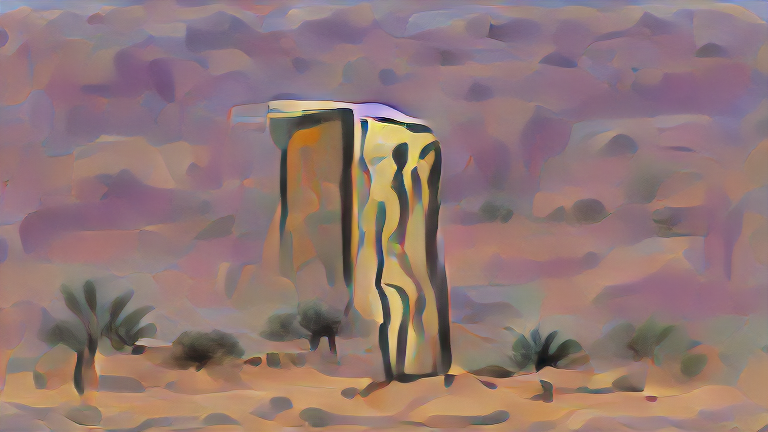

iter: 40, loss: 2.14, losses: 0.531, 0.0865, 0.675, 0.0687, 0.678, 0.0676, 0.0323 (-0=>2.139)


In [ ]:
#@title Output  { vertical-output: true }
save_progress = False #@param {type:"boolean"} 

#pixray.add_settings(output="temp.png")

if not save_progress:
  pixray.add_settings(display_clear=True)

settings = pixray.apply_settings()
pixray.do_init(settings)
pixray.do_run(settings)



In [ ]:

# examples below start with '#" are comments and do not get run
# pixray.add_settings(init_image="file.png")
# pixray.add_settings(init_image_alpha=200)
# pixray.add_settings(overlay_image="file.png")
# pixray.add_settings(image_prompts="file.png")
# pixray.add_settings(overlay_every=20)
# pixray.add_settings(display_every=50)
# pixray.add_settings(iterations=200)
# pixray.add_settings(size=[256, 256])
# pixray.add_settings(vector_prompts="textoff:4")
